# Transfomer 모델들을 사용해 에너지 예측 (BDG2)

참고
> https://github.com/buds-lab/building-data-genome-project-2
- BUDS Lab(University of Toronto)에서 주관한 공공 건물 에너지 사용량 예측 대회 및 연구 데이터셋
- 1,636개 건물에서 수집된 2년치(2016-2017) 시계열 에너지 데이터로 구성
- chilled water, gas, electricity, hotwater, irrigation, solar, steam, water 데이터 존재

## Import libraries

In [ ]:
# Import libraries and modules
import torch

from utils.preprocess_data import load_and_preprocess
from plots.plot import plot_data_by_month
from plots.plot import plot_forecast

from models.Transformer import TimeSeriesTransformer
from models.Informer import Informer
from models.Autoformer import Autoformer
from models.FEDformer import FEDformer
from models.PatchTST import PatchTST

from utils.train import train_model
from utils.metrics import mae, rmse, mape
from utils.test import test_model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load and Preprocess data

In [2]:
building_name = "Panther_office_Hannah"
elec_path= f"C:/Users/ryudo/OneDrive - gachon.ac.kr/AiCE2/석사논문/Transformer/BDG2/data/electricity.csv"
weather_path = f"C:/Users/ryudo/OneDrive - gachon.ac.kr/AiCE2/석사논문/Transformer/BDG2/data/weather.txt"
input_window = 168  # 입력 윈도우 크기
output_window = 24  # 출력 윈도우 크기

# 1. 데이터 불러오기 및 전처리
# preprocess_data.py
X_train, y_train, X_val, y_val, X_test, y_test, X_scaler, y_scaler = load_and_preprocess(elec_path, weather_path, input_window, output_window)

결측치 개수:
Series([], dtype: int64)
train: 2016-06-06 00:00:00 → 2017-05-28 00:00:00 (8568 rows)
valid: 2017-06-05 00:00:00 → 2017-08-27 00:00:00 (2016 rows)
test : 2017-09-04 00:00:00 → 2017-12-31 00:00:00 (2856 rows)
Train X: torch.Size([8377, 168, 17]) y: torch.Size([8377, 24, 1])
Valid  X: torch.Size([1825, 168, 17]) y: torch.Size([1825, 24, 1])
Test  X: torch.Size([2665, 168, 17]) y: torch.Size([2665, 24, 1])


## Data Visualization

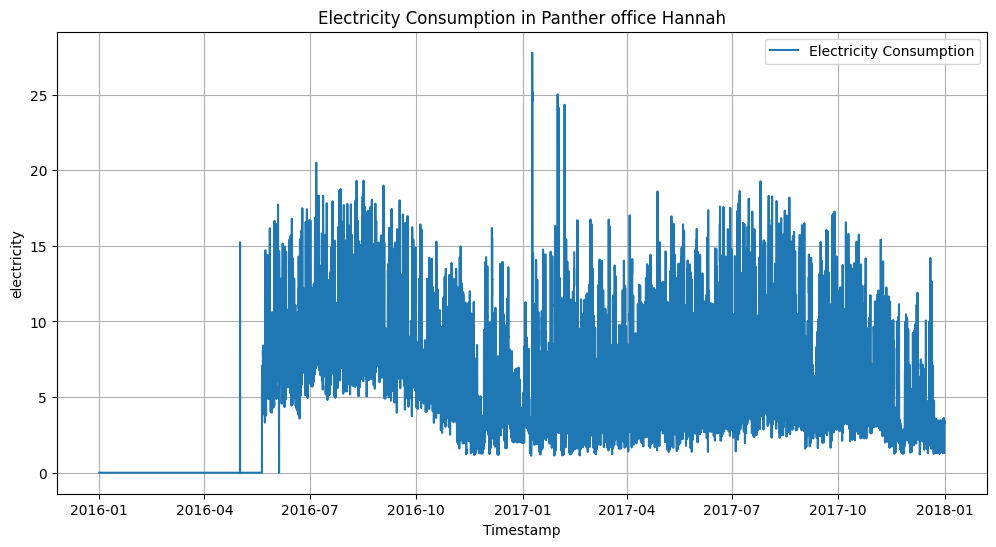

In [5]:
# 3. 데이터 시각화
# plot.py
# year = [2016, 2017]
# plot_data_by_month(elec_path, building_name, year, X_train, X_val)
import matplotlib.pyplot as plt
import pandas as pd
data = pd.read_csv(elec_path, parse_dates=["timestamp"])
# timestamp에 따른 electricity 데이터 시각화 
plt.figure(figsize=(12, 6))
plt.plot(data["timestamp"], data["Panther_office_Hannah"], label="Electricity Consumption")
plt.title("Electricity Consumption in Panther office Hannah")
plt.xlabel("Timestamp")
plt.ylabel("electricity")
plt.legend()
plt.grid()
plt.show()

## Model Initialization

### Transformer

In [6]:
# 하이퍼파라미터
d_model = 128 # 기본 64
nhead = 4
num_layers = 3
dim_feedforward = 512 # 기본 128
input_dim = X_train.shape[-1] 
dropout = 0.1
output_dim = 1  
pool="last"  

In [7]:
# Transformer 초기화
Transformer = TimeSeriesTransformer(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    output_window=output_window,
    dropout=dropout,
    pool=pool
).to(device)

print(Transformer)

TimeSeriesTransformer(
  (embedding): TimeSeriesEmbedding(
    (input_proj): Linear(in_features=17, out_features=128, bias=True)
    (pos_encoder): PositionalEncoding()
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (enc_norm

### Informer

In [8]:
max_len=512
head_hidden=256
use_decoder=False
d_layers=1  

# Informer 초기화
Informer = Informer(
    input_dim=input_dim,
    d_model=d_model,
    nhead=nhead,
    num_layers=num_layers,
    dim_feedforward=dim_feedforward,
    output_window=output_window,
    dropout=dropout,
    max_len=max_len,
    pool=pool,
    head_hidden=head_hidden,
    use_decoder=use_decoder,
    d_layers=d_layers
).to(device)

print(Informer)

Informer(
  (embedding): TimeSeriesEmbedding(
    (input_proj): Linear(in_features=17, out_features=128, bias=True)
    (pos_encoder): PositionalEncoding()
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Sequential(
    (0): EncoderLayer(
      (self_attn): ProbSparseSelfAttention(
        (q_proj): Linear(in_features=128, out_features=128, bias=True)
        (k_proj): Linear(in_features=128, out_features=128, bias=True)
        (v_proj): Linear(in_features=128, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
      (ff): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()

### Autoformer

In [9]:
input_len=168 # 과거 창 길이 (168, 336, 720 ...)
pred_len=24 # 예측 창 길이 (24, 48, 96 ...)
enc_layers = 2
dec_layers = 1
moving_avg = 24

# Autoformer 초기화
Autoformer = Autoformer(
    input_len=input_len,
    pred_len=pred_len, 
    d_model=d_model, 
    moving_avg=moving_avg,
    enc_layers=enc_layers, 
    dec_layers=dec_layers, 
    dropout=dropout, 
    input_dim=input_dim
).to(device)

print(Autoformer)

Autoformer(
  (enc_embedding): Linear(in_features=17, out_features=128, bias=True)
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (decomp1): SeriesDecomposition(
          (moving_avg): MovingAverage()
        )
        (auto_corr): AutoCorrelation()
        (dropout): Dropout(p=0.1, inplace=False)
        (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (ffn): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=128, out_features=128, bias=True)
        )
        (decomp2): SeriesDecomposition(
          (moving_avg): MovingAverage()
        )
        (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer

### FEDformer

In [10]:
mode_select_num=16
kernel_size=24

# FEDformer 초기화
FEDformer = FEDformer(
    input_dim=input_dim,
    d_model=d_model,
    output_window=output_window,
    mode_select_num=mode_select_num,
    kernel_size=kernel_size,
    dropout=dropout,
    pool=pool
).to(device)

print(FEDformer)

FEDformer(
  (input_proj): Linear(in_features=17, out_features=128, bias=True)
  (decomp): SeriesDecomposition(
    (moving_avg): MovingAverage()
  )
  (fourier): FourierBlock()
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (drop): Dropout(p=0.1, inplace=False)
  (decoder): Linear(in_features=128, out_features=24, bias=True)
)


### PatchTST

In [11]:
patch_size = 24 # 패치 크기 (예: 24시간 단위로 패치)

# PatchTST 초기화
PatchTST = PatchTST(
    input_window=input_window,
    patch_size=patch_size,
    input_dim=input_dim,
    d_model=d_model,
    output_window=output_window,
    num_layers=num_layers,
    nhead=nhead,
    dropout=dropout
).to(device)

print(PatchTST)

PatchTST(
  (embedding): PatchEmbedding(
    (proj): Linear(in_features=408, out_features=128, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (emb_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (emb_drop): Dropout(p=0.1, inplace=False)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (decoder): Linear(in_featu

## Training the models

In [12]:
# 모델 리스트 
model_list = [
    Transformer,
    Informer,
    Autoformer,
    FEDformer,
    PatchTST
]
batch_size = 128
lr = 1e-3 # 학습률
weight_decay = 1e-4 # 가중치 감쇠
num_epochs = 50

# 모델 학습 및 validation
for model in model_list:
    print(f"Training {model.__class__.__name__}...")
    train_model(
        model=model,
        X_train=X_train, y_train=y_train,
        X_val=X_val, y_val=y_val,
        X_test=X_test, y_test=y_test,
        batch_size=batch_size,
        lr=lr,
        weight_decay=weight_decay,
        num_epochs=num_epochs
    )
    print(f"----------{model.__class__.__name__} training complete.----------\n")

Training TimeSeriesTransformer...


c:\Users\ryudo\miniconda3\envs\torch_env\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


[최적 TimeSeriesTransformer모델 저장 완료] results/TimeSeriesTransformer-BDG2.pt
Epoch 001 | Train MAE: 0.0648 | Val MAE: 0.0499 (best 0.0499)
Epoch 002 | Train MAE: 0.0518 | Val MAE: 0.0660 (best 0.0499)
Epoch 003 | Train MAE: 0.0401 | Val MAE: 0.0539 (best 0.0499)
[최적 TimeSeriesTransformer모델 저장 완료] results/TimeSeriesTransformer-BDG2.pt
Epoch 004 | Train MAE: 0.0343 | Val MAE: 0.0331 (best 0.0331)
Epoch 005 | Train MAE: 0.0256 | Val MAE: 0.0364 (best 0.0331)
[최적 TimeSeriesTransformer모델 저장 완료] results/TimeSeriesTransformer-BDG2.pt
Epoch 006 | Train MAE: 0.0228 | Val MAE: 0.0314 (best 0.0314)
Epoch 007 | Train MAE: 0.0217 | Val MAE: 0.0354 (best 0.0314)
[최적 TimeSeriesTransformer모델 저장 완료] results/TimeSeriesTransformer-BDG2.pt
Epoch 008 | Train MAE: 0.0207 | Val MAE: 0.0306 (best 0.0306)
[최적 TimeSeriesTransformer모델 저장 완료] results/TimeSeriesTransformer-BDG2.pt
Epoch 009 | Train MAE: 0.0199 | Val MAE: 0.0280 (best 0.0280)
Epoch 010 | Train MAE: 0.0185 | Val MAE: 0.0330 (best 0.0280)
Epoch 011 | Tra

## Test & Evaluate

In [13]:
# # 모델 리스트
# model_list = [
#     Transformer,
#     Informer,
#     Autoformer,
#     FEDformer,
#     PatchTST
# ]

# # 모델 불러오기
# for model in model_list:
#     name = model.__class__.__name__
#     try:
#         model.load_state_dict(torch.load(f"models/{name}.pth"))
#         print(f"{name} 모델 불러오기")
#     except FileNotFoundError:
#         print(f"{name} 모델 파일이 존재하지 않습니다.")
#         exit()
        
results = {}
for model in model_list:
    name = model.__class__.__name__
    print(f"Evaluating {name}...")

    preds, trues = test_model(
        model=model,
        X_test=X_test,
        y_test=y_test,
        X_scaler=X_scaler,
        y_scaler=y_scaler
    )

    # 평가 지표 계산 
    mae_value  = mae(preds, trues)
    rmse_value = rmse(preds, trues)
    mape_value = mape(preds, trues)

    # 결과 저장
    results[name] = {
        "preds": preds,
        "trues": trues,
        "mae": mae_value,
        "rmse": rmse_value,
        "mape": mape_value,
    }

    # 출력
    try:
        print(f"[{model.__class__.__name__} 모델 성능] MAE: {mae_value:.4f}, RMSE: {rmse_value:.4f}, MAPE: {mape_value:.2f}%\n")
    except Exception:
        # 포맷 불가 시 일반 출력
        print(f"{name} - MAE: {mae_value}, RMSE: {rmse_value}, MAPE: {mape_value}\n")

Evaluating TimeSeriesTransformer...
[TimeSeriesTransformer 모델 성능] MAE: 0.3017, RMSE: 0.3890, MAPE: 16.89%

Evaluating Informer...
[Informer 모델 성능] MAE: 0.2747, RMSE: 0.3436, MAPE: 15.33%

Evaluating Autoformer...
[Autoformer 모델 성능] MAE: 0.3884, RMSE: 0.4546, MAPE: 20.20%

Evaluating FEDformer...
[FEDformer 모델 성능] MAE: 0.2980, RMSE: 0.3800, MAPE: 15.80%

Evaluating PatchTST...
[PatchTST 모델 성능] MAE: 0.3223, RMSE: 0.4037, MAPE: 17.59%



In [ ]:
# # 모델 저장
# for model in model_list:
#     name = model.__class__.__name__
#     torch.save(model.state_dict(), f"models/BDG2_Hannah{name}.pth")
#     print(f"{name} 모델이 저장되었습니다.")

TimeSeriesTransformer 모델이 저장되었습니다.
Informer 모델이 저장되었습니다.
Autoformer 모델이 저장되었습니다.
FEDformer 모델이 저장되었습니다.
PatchTST 모델이 저장되었습니다.


## Plot Result

In [15]:
sample_index = 0  # 시각화할 샘플 인덱스
import numpy as np

for model in model_list:
    name = model.__class__.__name__ # 모델 클래스명 문자열 추출

    preds = results[name]["preds"] # 해당 모델의 예측값 가져오기
    trues = results[name]["trues"] # 해당 모델의 실제값 가져오기

    # 시각화
    plot_forecast(
        model=model,
        preds=preds,
        trues=trues,
        input_window=input_window,
        output_window=output_window,
        sample_index=sample_index,
        X_test=X_test,
        x_scaler=X_scaler,
        y_scaler=y_scaler
    )

ValueError: operands could not be broadcast together with shapes (168,3) (7,) (168,3) 

## END